In [34]:
!pip install imageio matplotlib pillow numpy scipy

In [35]:
import tensorflow as tf

tf.config.run_functions_eagerly(True)
tf.autograph.set_verbosity(0)
tf.keras.backend.clear_session()
tf.data.experimental.enable_debug_mode = lambda: None


In [36]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = "/content/drive/MyDrive/dataset"
print("Using dataset:", DATASET_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using dataset: /content/drive/MyDrive/dataset


In [37]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import imageio
import tensorflow as tf




In [38]:
import tensorflow as tf
from tensorflow.keras import Model, layers

class SRCNN(Model):
    def __init__(self):
        super().__init__()
        self.c1 = layers.Conv2D(64, 9, padding="same", activation="relu")
        self.c2 = layers.Conv2D(32, 1, padding="same", activation="relu")
        self.c3 = layers.Conv2D(3, 5, padding="same")

    def call(self, x, training=False):
        return self.c3(self.c2(self.c1(x)))

model = SRCNN()


def compute_psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def compute_ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [39]:
import glob

class DataManager:
    def __init__(self, root, patch_size=33):
        self.patch_size = patch_size

        self.train_lr = sorted(glob.glob(root + "/train_lr/*.npy"))
        self.train_hr = sorted(glob.glob(root + "/train_hr/*.npy"))

        self.test_lr  = sorted(glob.glob(root + "/test_lr/*.npy"))
        self.test_hr  = sorted(glob.glob(root + "/test_hr/*.npy"))

        print("Train samples:", len(self.train_lr))
        print("Test samples :", len(self.test_lr))

    def _load_and_fix(self, img):
        img = img.astype(np.float32)
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        img = img * 255.0
        img = img / 255.0

        return img

    def random_patch(self, lr_img, hr_img):
        H, W, _ = lr_img.shape
        ps = self.patch_size

        x = random.randint(0, H - ps)
        y = random.randint(0, W - ps)

        return lr_img[x:x+ps, y:y+ps, :], hr_img[x:x+ps, y:y+ps, :]

    def get_batch(self, bs=8):
        lr_batch = []
        hr_batch = []

        for _ in range(bs):
            idx = random.randint(0, len(self.train_lr)-1)

            lr = np.load(self.train_lr[idx])
            hr = np.load(self.train_hr[idx])
            lr = self._load_and_fix(lr)
            hr = self._load_and_fix(hr)

            lr_patch, hr_patch = self.random_patch(lr, hr)

            lr_batch.append(lr_patch)
            hr_batch.append(hr_patch)

        return np.array(lr_batch), np.array(hr_batch)

    def get_test(self):
        lr_imgs = []
        hr_imgs = []

        for fl, fh in zip(self.test_lr, self.test_hr):
            lr = self._load_and_fix(np.load(fl))
            hr = self._load_and_fix(np.load(fh))
            lr_imgs.append(lr)
            hr_imgs.append(hr)

        return lr_imgs, hr_imgs




def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)
dm = DataManager(DATASET_PATH, patch_size=33)

print("Train LR:", len(dm.train_lr))
print("Train HR:", len(dm.train_hr))

Train samples: 90
Test samples : 10
Train LR: 90
Train HR: 90


In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.optimizers import Adam

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def build_srcnn(lr=1e-4):
    inp = Input(shape=(None, None, 3))

    c1 = Conv2D(64, 9, padding="same", activation="relu")(inp)
    c2 = Conv2D(32, 1, padding="same", activation="relu")(c1)
    out = Conv2D(3, 5, padding="same")(c2)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(lr),
        loss="mse",
        metrics=[psnr_metric]
    )
    return model

model = build_srcnn()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None, 64) │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None, 32) │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None, 3)  │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,099 (78.51 KB)

 Trainable params: 20,099 (78.51 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
EPOCHS = 3
STEPS = 200
BATCH = 8


In [42]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss_fn = tf.keras.losses.MeanSquaredError()

loss_history = []
psnr_history = []
ssim_history = []

for epoch in range(EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")

    for step in range(STEPS):
        lr_batch, hr_batch = dm.get_batch(BATCH)

        with tf.GradientTape() as tape:
            preds = model(lr_batch, training=True)
            loss = loss_fn(hr_batch, preds)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        psnr = compute_psnr(hr_batch, preds)
        ssim = compute_ssim(hr_batch, preds)

        loss_val = float(loss)
        psnr_val = float(tf.reduce_mean(psnr))
        ssim_val = float(tf.reduce_mean(ssim))

        loss_history.append(loss_val)
        psnr_history.append(psnr_val)
        ssim_history.append(ssim_val)

        if step % 20 == 0:
            print(f"Step {step}/{STEPS} | "
                  f"Loss: {loss_val:.6f} | "
                  f"PSNR: {psnr_val:.3f} | "
                  f"SSIM: {ssim_val:.4f}")



=== Epoch 1/3 ===
Step 0/200 | Loss: 0.331798 | PSNR: 5.861 | SSIM: -0.0946
Step 20/200 | Loss: 0.117299 | PSNR: 10.269 | SSIM: 0.2929
Step 40/200 | Loss: 0.046202 | PSNR: 13.870 | SSIM: 0.4015
Step 60/200 | Loss: 0.041770 | PSNR: 14.149 | SSIM: 0.3711
Step 80/200 | Loss: 0.039175 | PSNR: 16.633 | SSIM: 0.4629
Step 100/200 | Loss: 0.033192 | PSNR: 15.596 | SSIM: 0.4595
Step 120/200 | Loss: 0.027429 | PSNR: 16.359 | SSIM: 0.5175
Step 140/200 | Loss: 0.015112 | PSNR: 18.515 | SSIM: 0.5583
Step 160/200 | Loss: 0.014339 | PSNR: 19.922 | SSIM: 0.7050
Step 180/200 | Loss: 0.018627 | PSNR: 17.734 | SSIM: 0.6119

=== Epoch 2/3 ===
Step 0/200 | Loss: 0.016370 | PSNR: 19.086 | SSIM: 0.6198
Step 20/200 | Loss: 0.014392 | PSNR: 19.755 | SSIM: 0.6297
Step 40/200 | Loss: 0.017015 | PSNR: 18.786 | SSIM: 0.6931
Step 60/200 | Loss: 0.010471 | PSNR: 21.135 | SSIM: 0.6633
Step 80/200 | Loss: 0.011847 | PSNR: 20.649 | SSIM: 0.7306
Step 100/200 | Loss: 0.014091 | PSNR: 20.269 | SSIM: 0.7574
Step 120/200 |

In [43]:
model.save("/content/srcnn_model.h5")
print("Model saved!")

Model saved!


In [44]:
lr_imgs, hr_imgs = dm.get_test()

os.makedirs("/content/results", exist_ok=True)

for i in range(len(lr_imgs)):
    lr = lr_imgs[i][None, ...]
    sr = model.predict(lr)[0]

    imageio.imwrite(f"/content/results/lr_{i}.png", (lr_imgs[i] * 255).astype(np.uint8))
    imageio.imwrite(f"/content/results/hr_{i}.png", (hr_imgs[i] * 255).astype(np.uint8))
    imageio.imwrite(f"/content/results/sr_{i}.png", (sr * 255).astype(np.uint8))

print("Saved!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Saved!


/tmp/ipython-input-1708731399.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  axs[0].imshow(imageio.imread(l))
/tmp/ipython-input-1708731399.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  axs[1].imshow(imageio.imread(p))
/tmp/ipython-input-1708731399.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  axs[2].imshow(imageio.imread(h))


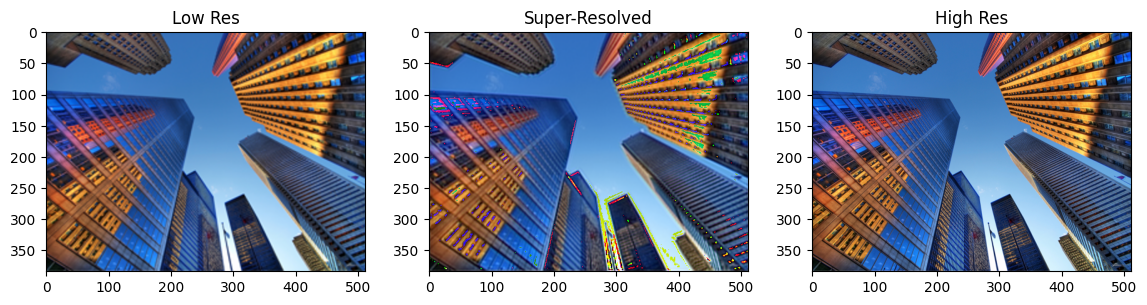

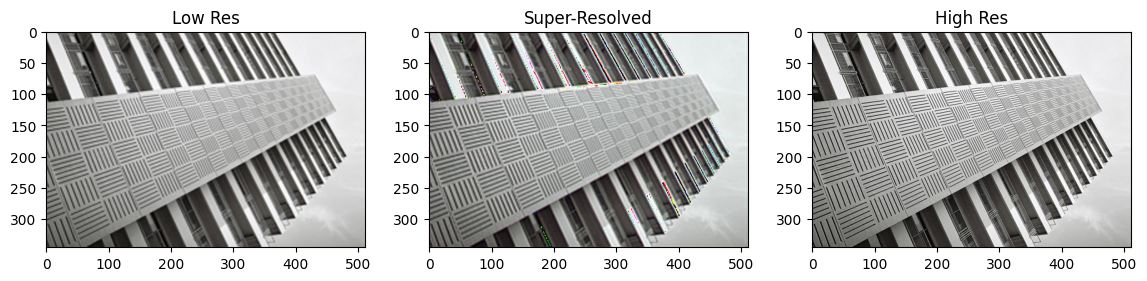

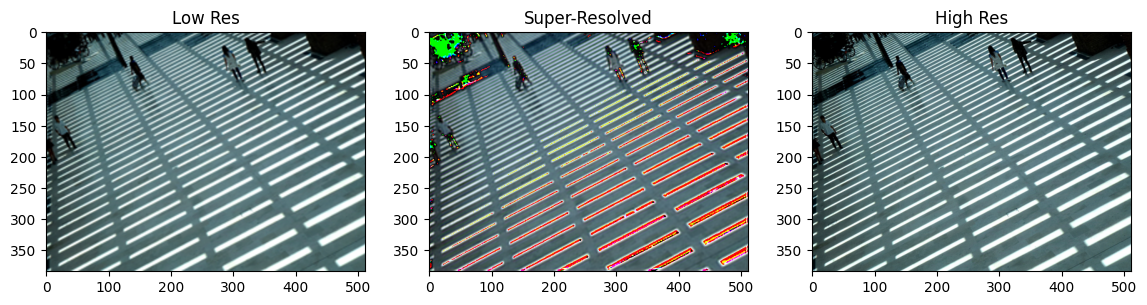

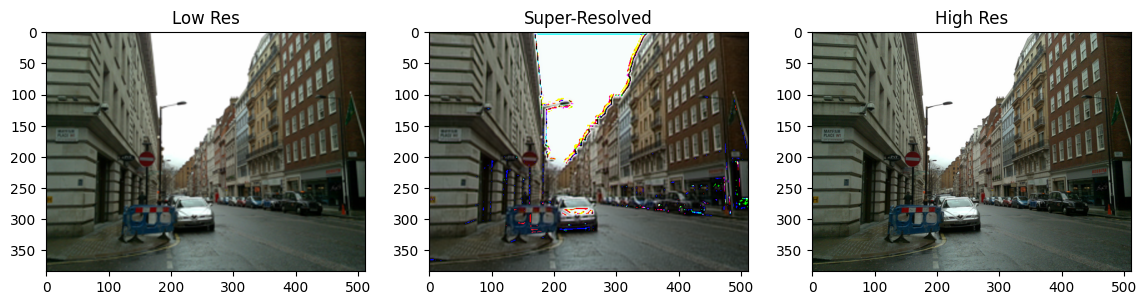

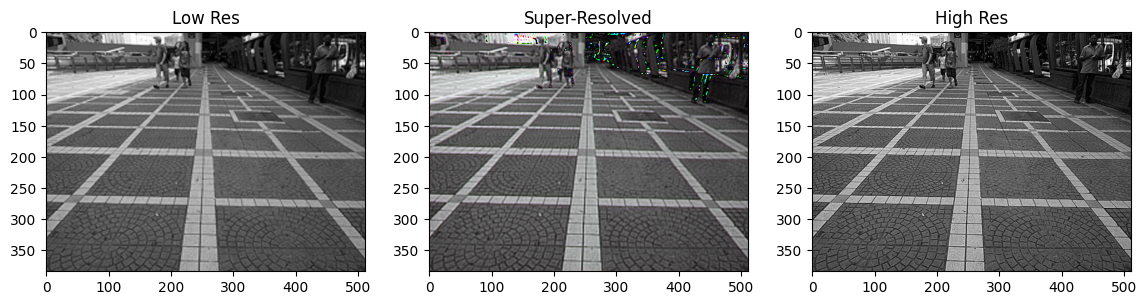

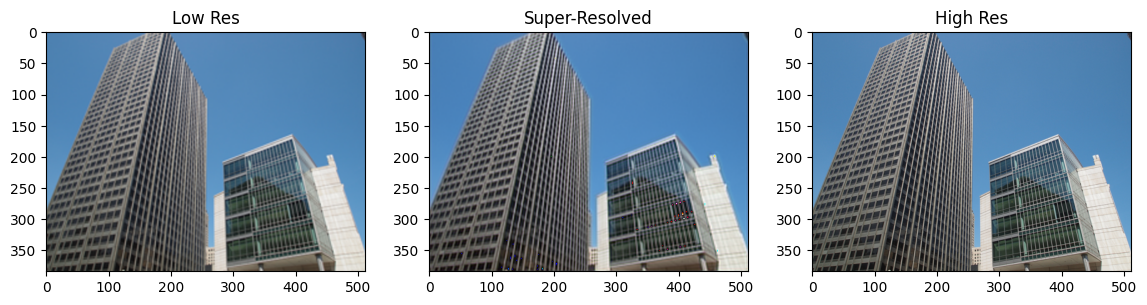

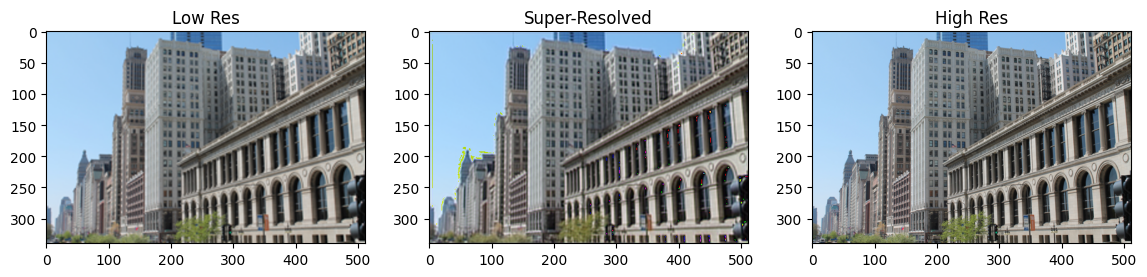

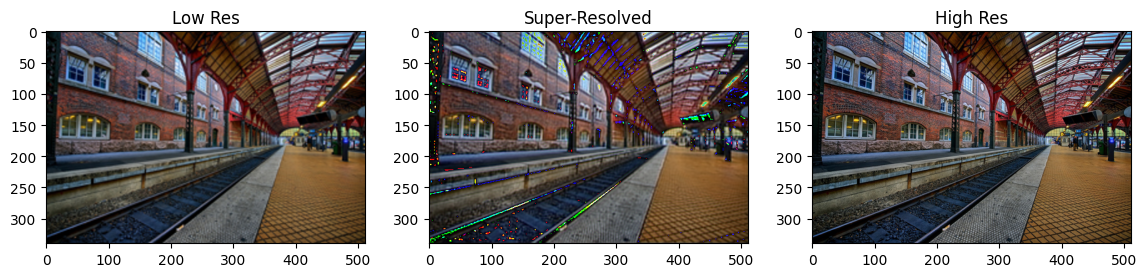

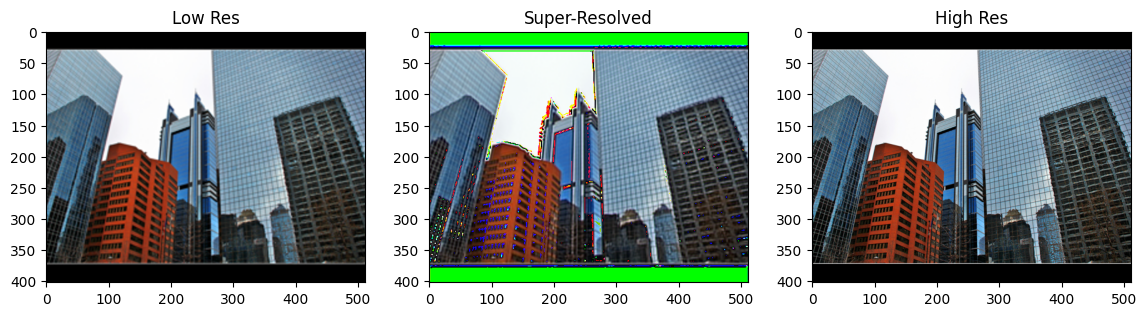

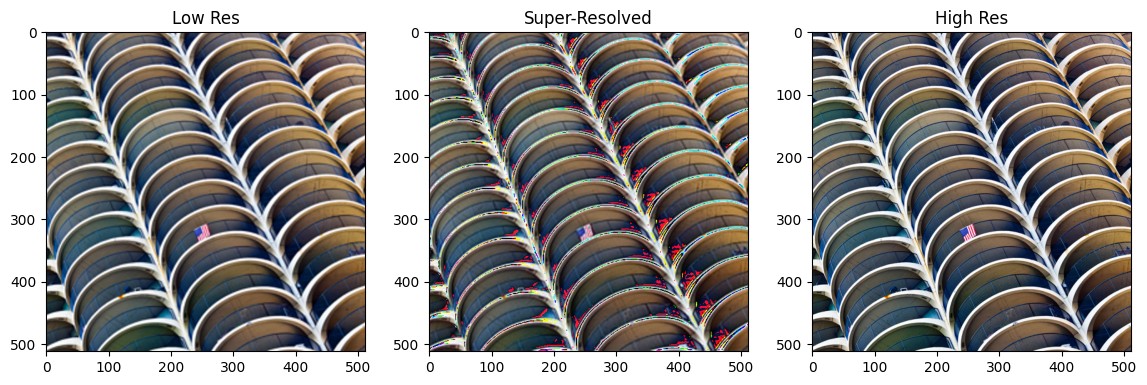

In [45]:

import matplotlib.pyplot as plt
import imageio

import glob

preds = sorted(glob.glob("/content/results/sr_*.png"))
hrs   = sorted(glob.glob("/content/results/hr_*.png"))
lrs   = sorted(glob.glob("/content/results/lr_*.png"))

for p, h, l in zip(preds, hrs, lrs):
    fig, axs = plt.subplots(1, 3, figsize=(14,5))
    axs[0].imshow(imageio.imread(l))
    axs[0].set_title("Low Res")

    axs[1].imshow(imageio.imread(p))
    axs[1].set_title("Super-Resolved")

    axs[2].imshow(imageio.imread(h))
    axs[2].set_title("High Res")

    plt.show()

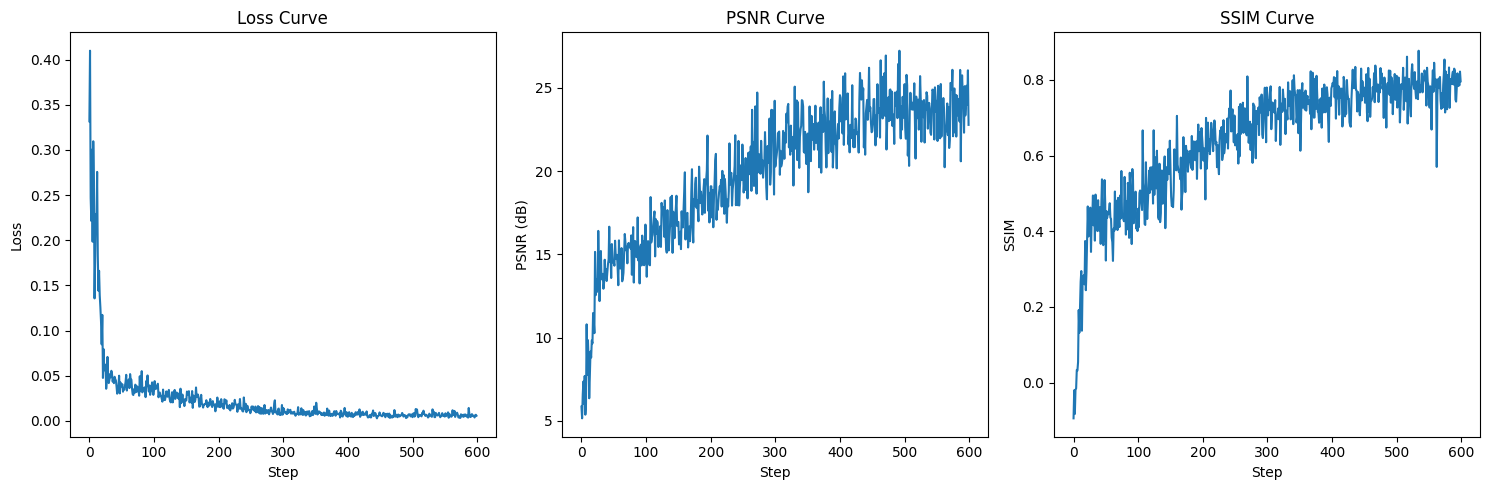

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(loss_history)
plt.title("Loss Curve")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.subplot(1,3,2)
plt.plot(psnr_history)
plt.title("PSNR Curve")
plt.xlabel("Step")
plt.ylabel("PSNR (dB)")

plt.subplot(1,3,3)
plt.plot(ssim_history)
plt.title("SSIM Curve")
plt.xlabel("Step")
plt.ylabel("SSIM")

plt.tight_layout()
plt.show()
